In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset-03/training_def.csv
/kaggle/input/dataset-03/test_def.csv
/kaggle/input/tr-ts-final/part-00000-61dceaf6-d1b0-4f2f-bced-e4c878153d15-c000.csv
/kaggle/input/tr-ts-final/part-00000-7b36d2f4-10c1-4ffd-b814-15a10cfcad6d-c000.csv


In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 14.0 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845513 sha256=ed19651d32828bd0d0815f01cd0303a2dc0c7a096fba2abf5d916a11b80d8d54
  Stored in directory: /root/.cache/pip/wheels/42/59/f5/79a5bf931714dcd201b26025347785f087370a10a3329a899c
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [3]:
from pyspark.sql import SparkSession
spark=SparkSession.builder.master("local[*]").getOrCreate()
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/16 13:51:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SQLContext, SparkSession
import pyspark.sql.functions as F
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.linalg import Vectors
from pyspark.sql.types import Row

# Importing required libraries for VIF Calculation
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import DenseVector
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.sql.functions import coalesce
import pyspark.ml.feature as MF

In [5]:
path =  '/kaggle/input/tr-ts-final/part-00000-61dceaf6-d1b0-4f2f-bced-e4c878153d15-c000.csv'
df = spark.read.option("escape","\"").csv(path, header='true', inferSchema='true')

In [6]:
path_TS = '/kaggle/input/tr-ts-final/part-00000-7b36d2f4-10c1-4ffd-b814-15a10cfcad6d-c000.csv'
TS = spark.read.option("escape","\"").csv(path_TS, header='true', inferSchema='true')
TS_copy = TS.alias('TS_copy')

In [7]:
df.show(5)

+---+------------------+-------------------+-----+----+------------------+-----------------+----+----------+------+---------+----------+-------+
|_c0|          latitude|          longitude|depth| mag|               nst|              gap| rms|depthError|magNst|time_unix|      type|magType|
+---+------------------+-------------------+-----+----+------------------+-----------------+----+----------+------+---------+----------+-------+
|  1|39.100333299999996|          -122.0095|4.691|2.06|              19.0|            120.0|0.16|      3.35|  12.0|486345334|earthquake|     md|
| 12|              46.2|-122.18866670000001|-0.39| 2.1|              13.0|            102.0|0.09|      0.26|   3.0|486339393|earthquake|     md|
| 26|        46.1993333|-122.18966670000002|-0.48| 2.6|              18.0|             72.0|0.13|      0.28|   3.0|486332009|earthquake|     md|
| 28|            28.551|            140.489| 52.4| 4.9|-5.899129402172753|74.43572757651071| 1.0|      11.1|  13.0|486331234|earth

In [8]:
TS.show(5)

+---+------------------+-------------------+-------------------+----+----+-----+-----+----------+------+---------+----------+-------+
|_c0|          latitude|          longitude|              depth| mag| nst|  gap|  rms|depthError|magNst|time_unix|      type|magType|
+---+------------------+-------------------+-------------------+----+----+-----+-----+----------+------+---------+----------+-------+
|  6|            33.944|           -117.194|             13.905|2.25| 0.0| 58.6|0.162|     0.733|  43.0|486342393|earthquake|     mc|
| 16|        46.1991667|-122.18433329999999|               0.04| 2.8|19.0| 73.0| 0.16|      0.32|   3.0|486337708|earthquake|     md|
| 34|46.201666700000004|          -122.1905|              -0.09| 2.0|14.0| 69.0| 0.12|      0.29|   2.0|486329011|earthquake|     md|
| 86|35.849166700000005|-121.36716670000001|              8.039|2.11|29.0|191.0| 0.18|      0.49|  18.0|486311653|earthquake|     md|
|140|            38.809|-122.82066670000002|-0.954000000000000

In [9]:
df.count()

2056385

In [10]:
TS.count()

514023

In [11]:
df.columns

['_c0',
 'latitude',
 'longitude',
 'depth',
 'mag',
 'nst',
 'gap',
 'rms',
 'depthError',
 'magNst',
 'time_unix',
 'type',
 'magType']

### The current dataset we are using is the TR

Classification

1. Outliers
2. Correlation (chi-square)
3. OHE for magType + binary for target type
4. Random Forest


# 1. Outliers

In [12]:
def find_outliers(df):



   # Identifying the numerical columns in a spark dataframe
    numeric_columns = [column[0] for column in df.dtypes if column[0] != '_c0' and column[0] != 'type' and column[0] != 'magType']



   # Using the `for` loop to create new columns by identifying the outliers for each feature
    for column in numeric_columns:



        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)



       # Q1 : First Quartile ., Q3 : Third Quartile
        Q1 = df.approxQuantile(column,[0.25],relativeError=0)
        Q3 = df.approxQuantile(column,[0.75],relativeError=0)
        
        # IQR : Inter Quantile Range
        # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
        # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
        IQR = Q3[0] - Q1[0]
        
        #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
        less_Q1 =  Q1[0] - 4*IQR
        more_Q3 =  Q3[0] + 4*IQR
        
        isOutlierCol = 'is_outlier_{}'.format(column)
        
        df = df.withColumn(isOutlierCol,F.when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))
        
    # Selecting the specific columns which we have added above, to check if there are any outliers
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]
    # Adding all the outlier columns into a new colum "total_outliers", to see the total number of outliers
    df_no_out2 = df.withColumn('total_outliers',sum(df[column] for column in selected_columns))
    
    # Dropping the extra columns created above, just to create nice dataframe., without extra columns
    TR_outliers = df_no_out2.drop(*[column for column in df_no_out2.columns if column.startswith("is_outlier")])
    
    train_no_out = TR_outliers.filter(TR_outliers['total_Outliers']== 0)
    train_no_out = train_no_out.drop('total_Outliers')


    return train_no_out

In [13]:
df_no_outliers = find_outliers(df)

In [14]:
df_no_outliers.count()

1557238

NB: It could seem strange that now we don't detect any outlier by using the 3 coefficient. This is due to the fact that now the TR has changed with respect to before, when TR was smaller and different than now.

# 2. Correlation
We'll use a binning technique, because we'll use a chi-square test

In [15]:
from pyspark.ml.stat import ChiSquareTest

In [16]:
df_bins = df_no_outliers.alias('bins')

In [17]:
from pyspark.ml.feature import QuantileDiscretizer
from pyspark.ml.feature import Bucketizer
cols = [col for col in df_bins.columns if col != '_c0' and col != 'type' and col!='magType']
for col in cols:
    qds = QuantileDiscretizer(numBuckets=5,inputCol=col, outputCol=col+'_dis', relativeError=0.01, handleInvalid="error")
    df_bins = qds.fit(df_bins).transform(df_bins)
    df_bins = df_bins.drop(col)

In [18]:
df_bins.show(5)

+---+----------+-------+------------+-------------+---------+-------+-------+-------+-------+--------------+----------+-------------+
|_c0|      type|magType|latitude_dis|longitude_dis|depth_dis|mag_dis|nst_dis|gap_dis|rms_dis|depthError_dis|magNst_dis|time_unix_dis|
+---+----------+-------+------------+-------------+---------+-------+-------+-------+-------+--------------+----------+-------------+
|  1|earthquake|     md|         3.0|          2.0|      2.0|    4.0|    3.0|    2.0|    3.0|           4.0|       3.0|          0.0|
| 12|earthquake|     md|         3.0|          1.0|      0.0|    4.0|    2.0|    1.0|    2.0|           0.0|       1.0|          0.0|
| 26|earthquake|     md|         3.0|          1.0|      0.0|    4.0|    3.0|    0.0|    2.0|           0.0|       1.0|          0.0|
| 31|earthquake|     md|         1.0|          3.0|      1.0|    0.0|    0.0|    4.0|    0.0|           2.0|       1.0|          0.0|
| 52|     other|     md|         4.0|          2.0|      2.0| 

# 3. OHE
We need to binaryze the target variable and perform OHE on magType

In [19]:
df_feat_sel = df_no_outliers.withColumn("earthquake", F.when(df_no_outliers.type == 'earthquake',1).otherwise(0))
df_feat_sel = df_feat_sel.drop('type')

#already proceed with TS binarization
TS = TS.withColumn("earthquake", F.when(TS.type == 'earthquake',1).otherwise(0))
TS = TS.drop('type')

from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol='magType', outputCol='magType_numeric')
indexer_fitted_magType = indexer.fit(df_feat_sel)
df_feat_sel_final = indexer_fitted_magType.transform(df_feat_sel)
TS = indexer_fitted_magType.transform(TS)

In [20]:
df_feat_sel_final.show(5)

+---+------------------+-------------------+-----------------+----+----+-----+----+----------+------+---------+-------+----------+---------------+
|_c0|          latitude|          longitude|            depth| mag| nst|  gap| rms|depthError|magNst|time_unix|magType|earthquake|magType_numeric|
+---+------------------+-------------------+-----------------+----+----+-----+----+----------+------+---------+-------+----------+---------------+
|  1|39.100333299999996|          -122.0095|            4.691|2.06|19.0|120.0|0.16|      3.35|  12.0|486345334|     md|         1|            0.0|
| 12|              46.2|-122.18866670000001|            -0.39| 2.1|13.0|102.0|0.09|      0.26|   3.0|486339393|     md|         1|            0.0|
| 26|        46.1993333|-122.18966670000002|            -0.48| 2.6|18.0| 72.0|0.13|      0.28|   3.0|486332009|     md|         1|            0.0|
| 31|        37.4418333|-118.63533329999999|             3.58|0.13| 4.0|213.0|0.01|      0.98|   1.0|486330689|     md

We can already proceed with Chi-Square test, because it does not require magType to be One Hot Encoded.
However, we already create the OHEncoded dataset, so that later we can perform our classification task.

In [21]:
encoder = OneHotEncoder(inputCols = ["magType_numeric"],outputCols = ["OHE_magType"])
df_onehot = encoder.fit(df_feat_sel_final).transform(df_feat_sel_final)
TS = encoder.fit(TS).transform(TS)
df_onehot.show(5)

# put columns in the right place
from pyspark.ml.functions import vector_to_array
df_col_onehot = df_onehot.select('*',vector_to_array("OHE_magType").alias('col_OHE_magType'))
df_col_onehot_test = TS.select('*',vector_to_array("OHE_magType").alias('col_OHE_magType'))
df_col_onehot.show(5)
num_categories_magType = len(df_col_onehot.first()['col_OHE_magType'])
cols_expanded_magType = [(F.col('col_OHE_magType')[i].alias("magType_"+f'{indexer_fitted_magType.labels[i]}')) for i in range(num_categories_magType)]
df_cols_onehot = df_col_onehot.select('_c0','earthquake', 'magType_numeric',*cols_expanded_magType)
TS = df_col_onehot_test.select('_c0','earthquake', *cols_expanded_magType)
df_cols_onehot.show(5)  #this contains magtypenumeric, earthquake and is OHEncoded
TS.show(5)

+---+------------------+-------------------+-----------------+----+----+-----+----+----------+------+---------+-------+----------+---------------+-------------+
|_c0|          latitude|          longitude|            depth| mag| nst|  gap| rms|depthError|magNst|time_unix|magType|earthquake|magType_numeric|  OHE_magType|
+---+------------------+-------------------+-----------------+----+----+-----+----+----------+------+---------+-------+----------+---------------+-------------+
|  1|39.100333299999996|          -122.0095|            4.691|2.06|19.0|120.0|0.16|      3.35|  12.0|486345334|     md|         1|            0.0|(6,[0],[1.0])|
| 12|              46.2|-122.18866670000001|            -0.39| 2.1|13.0|102.0|0.09|      0.26|   3.0|486339393|     md|         1|            0.0|(6,[0],[1.0])|
| 26|        46.1993333|-122.18966670000002|            -0.48| 2.6|18.0| 72.0|0.13|      0.28|   3.0|486332009|     md|         1|            0.0|(6,[0],[1.0])|
| 31|        37.4418333|-118.63533

In [22]:
bins = df_bins.drop(*['type', 'magType'])
cat = df_feat_sel_final.drop( *[col for col in df_feat_sel_final.columns if col != 'earthquake' and col != 'magType_numeric' and col != '_c0'])

In [23]:
chisq = bins.join(cat, '_c0')
chisq.show(5)

+---+------------+-------------+---------+-------+-------+-------+-------+--------------+----------+-------------+----------+---------------+
|_c0|latitude_dis|longitude_dis|depth_dis|mag_dis|nst_dis|gap_dis|rms_dis|depthError_dis|magNst_dis|time_unix_dis|earthquake|magType_numeric|
+---+------------+-------------+---------+-------+-------+-------+-------+--------------+----------+-------------+----------+---------------+
|  1|         3.0|          2.0|      2.0|    4.0|    3.0|    2.0|    3.0|           4.0|       3.0|          0.0|         1|            0.0|
| 12|         3.0|          1.0|      0.0|    4.0|    2.0|    1.0|    2.0|           0.0|       1.0|          0.0|         1|            0.0|
| 26|         3.0|          1.0|      0.0|    4.0|    3.0|    0.0|    2.0|           0.0|       1.0|          0.0|         1|            0.0|
| 31|         1.0|          3.0|      1.0|    0.0|    0.0|    4.0|    0.0|           2.0|       1.0|          0.0|         1|            0.0|
| 52| 

In [24]:
from pyspark.ml.feature import VectorAssembler
cols = [col for col in chisq.columns if col != '_c0' and col != 'earthquake']
assembler = VectorAssembler().setInputCols(cols).setOutputCol("chisq")
corr_vect = assembler.transform(chisq)

chiSqResult = ChiSquareTest.test(corr_vect, 'chisq', 'earthquake',flatten=True)

In [25]:
# H0: X ind. Y
chiSqResult.show()

+------------+------+----------------+------------------+
|featureIndex|pValue|degreesOfFreedom|         statistic|
+------------+------+----------------+------------------+
|           4|   0.0|               4| 984.8517621876698|
|           0|   0.0|               4| 4807.453700636395|
|           8|   0.0|               4| 3867.993448075864|
|           1|   0.0|               4| 7097.625575191509|
|           9|   0.0|               4| 8259.834288147442|
|           5|   0.0|               4|1505.4776957608583|
|           6|   0.0|               4| 6063.909982607921|
|          10|   0.0|               6| 3179.755151649689|
|           2|   0.0|               4|  85189.0911283729|
|           3|   0.0|               4|12645.618446063008|
|           7|   0.0|               4| 8510.560398246484|
+------------+------+----------------+------------------+



### Create OHE TR

In [26]:
df_cols_onehot = df_cols_onehot.drop('magType_numeric')

In [27]:
df_cols_onehot = df_cols_onehot.drop('magType_numeric')
df_feat_sel_final = df_feat_sel_final.drop(*['magType_numeric', 'earthquake', 'magType'])
TR = df_feat_sel_final.join(df_cols_onehot, '_c0')
TR.show(5)

##### prepare TS ####
TS2 = TS_copy.drop(*['type', 'magType'])
TS = TS2.join(TS, '_c0')
TS.show(5)

+---+------------------+-------------------+-----------------+----+----+-----+----+----------+------+---------+----------+----------+----------+----------+----------+-----------+----------+
|_c0|          latitude|          longitude|            depth| mag| nst|  gap| rms|depthError|magNst|time_unix|earthquake|magType_md|magType_ml|magType_mc|magType_mh|magType_mdl|magType_mb|
+---+------------------+-------------------+-----------------+----+----+-----+----+----------+------+---------+----------+----------+----------+----------+----------+-----------+----------+
|  1|39.100333299999996|          -122.0095|            4.691|2.06|19.0|120.0|0.16|      3.35|  12.0|486345334|         1|       1.0|       0.0|       0.0|       0.0|        0.0|       0.0|
| 12|              46.2|-122.18866670000001|            -0.39| 2.1|13.0|102.0|0.09|      0.26|   3.0|486339393|         1|       1.0|       0.0|       0.0|       0.0|        0.0|       0.0|
| 26|        46.1993333|-122.18966670000002|      

+---+------------------+-------------------+-------------------+----+----+-----+-----+----------+------+---------+----------+----------+----------+----------+----------+-----------+----------+
|_c0|          latitude|          longitude|              depth| mag| nst|  gap|  rms|depthError|magNst|time_unix|earthquake|magType_md|magType_ml|magType_mc|magType_mh|magType_mdl|magType_mb|
+---+------------------+-------------------+-------------------+----+----+-----+-----+----------+------+---------+----------+----------+----------+----------+----------+-----------+----------+
|  6|            33.944|           -117.194|             13.905|2.25| 0.0| 58.6|0.162|     0.733|  43.0|486342393|         1|       0.0|       0.0|       1.0|       0.0|        0.0|       0.0|
| 16|        46.1991667|-122.18433329999999|               0.04| 2.8|19.0| 73.0| 0.16|      0.32|   3.0|486337708|         1|       1.0|       0.0|       0.0|       0.0|        0.0|       0.0|
| 34|46.201666700000004|          -

# 4. Random Forest

In [28]:
from pyspark.ml.classification import RandomForestClassifier

Instead of applying a under or over sampling, we can directly calculate the weight to apply to each value of the column 'earthquake'

In [29]:
count_earth = TR[TR['earthquake']==1].count()
count_total = TR.count()

c = 2
weight_earth = TR.count() / (c * count_earth)
weight_no_earth = TR.count() / (c * (count_total - count_earth))

TR = TR.withColumn("weight", F.when(F.col("earthquake") == 1, weight_earth).otherwise(weight_no_earth))

print('earthquake = 1 weight: ', weight_earth)
print('earthquake = 0 weight: ', weight_no_earth)

earthquake = 1 weight:  0.5098854193747802
earthquake = 0 weight:  25.78977178629393


In [30]:
TR.show(5)

+---+------------------+-------------------+-----------------+----+----+-----+----+----------+------+---------+----------+----------+----------+----------+----------+-----------+----------+------------------+
|_c0|          latitude|          longitude|            depth| mag| nst|  gap| rms|depthError|magNst|time_unix|earthquake|magType_md|magType_ml|magType_mc|magType_mh|magType_mdl|magType_mb|            weight|
+---+------------------+-------------------+-----------------+----+----+-----+----+----------+------+---------+----------+----------+----------+----------+----------+-----------+----------+------------------+
|  1|39.100333299999996|          -122.0095|            4.691|2.06|19.0|120.0|0.16|      3.35|  12.0|486345334|         1|       1.0|       0.0|       0.0|       0.0|        0.0|       0.0|0.5098854193747802|
| 12|              46.2|-122.18866670000001|            -0.39| 2.1|13.0|102.0|0.09|      0.26|   3.0|486339393|         1|       1.0|       0.0|       0.0|       0.

In [31]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

In [32]:
def classification(df_train, target):
    # Use vectors again 
    cols = [col for col in df_train.columns if col != '_c0' and col != target and col != 'weight']
    assembler = VectorAssembler().setInputCols(cols).setOutputCol("vect")
    final_TR = assembler.transform(df_train)

    rf = RandomForestClassifier( featuresCol= 'vect', 
                                labelCol= 'earthquake',seed= 0, weightCol = 'weight')
    
    #GridSearch
    paramGrid = ParamGridBuilder().addGrid(rf.maxDepth, [18])\
    .addGrid(rf.impurity, ['gini'])\
    .addGrid(rf.numTrees, [20])\
    .addGrid(rf.bootstrap,[True])\
    .addGrid(rf.featureSubsetStrategy, ['11'])\
    .addGrid(rf.minInstancesPerNode, [150])\
    .build() 
    
    pipeline = Pipeline(stages = [rf])
    
    evaluator = BinaryClassificationEvaluator(rawPredictionCol = 'prediction', labelCol= target, metricName='areaUnderROC') 

    crossval = CrossValidator(estimator = pipeline,
                          estimatorParamMaps = paramGrid,
                          evaluator = evaluator,
                          numFolds = 4, seed = 0)
    
    model = crossval.fit(final_TR)
    
    print("avg folds' AUC: ", model.avgMetrics)
    
    return model

In [33]:
model_retr = classification(TR, 'earthquake')

22/12/16 13:55:09 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


22/12/16 13:56:45 WARN DAGScheduler: Broadcasting large task binary with size 1214.0 KiB


22/12/16 13:57:04 WARN DAGScheduler: Broadcasting large task binary with size 1725.9 KiB


22/12/16 13:57:28 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/12/16 13:57:56 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


22/12/16 13:58:25 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


22/12/16 13:58:55 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/12/16 13:59:22 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


22/12/16 13:59:49 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/12/16 14:00:12 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/12/16 14:00:34 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/12/16 14:01:02 WARN DAGScheduler: Broadcasting large task binary with size 1536.4 KiB


22/12/16 14:02:39 WARN DAGScheduler: Broadcasting large task binary with size 1197.9 KiB


22/12/16 14:02:58 WARN DAGScheduler: Broadcasting large task binary with size 1728.1 KiB


22/12/16 14:03:23 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/12/16 14:03:51 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


22/12/16 14:04:20 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/12/16 14:04:51 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/12/16 14:05:19 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


22/12/16 14:05:46 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


22/12/16 14:06:11 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/12/16 14:06:34 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


22/12/16 14:07:03 WARN DAGScheduler: Broadcasting large task binary with size 1562.1 KiB


22/12/16 14:08:38 WARN DAGScheduler: Broadcasting large task binary with size 1245.9 KiB


22/12/16 14:08:58 WARN DAGScheduler: Broadcasting large task binary with size 1786.7 KiB


22/12/16 14:09:24 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/12/16 14:09:53 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


22/12/16 14:10:23 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/12/16 14:10:56 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/12/16 14:11:25 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


22/12/16 14:11:53 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


22/12/16 14:12:18 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/12/16 14:12:42 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/12/16 14:13:11 WARN DAGScheduler: Broadcasting large task binary with size 1551.2 KiB


22/12/16 14:14:45 WARN DAGScheduler: Broadcasting large task binary with size 1191.6 KiB


22/12/16 14:15:04 WARN DAGScheduler: Broadcasting large task binary with size 1696.9 KiB


22/12/16 14:15:28 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/12/16 14:15:56 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


22/12/16 14:16:26 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


22/12/16 14:16:58 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/12/16 14:17:27 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


22/12/16 14:17:54 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


22/12/16 14:18:20 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/12/16 14:18:43 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


22/12/16 14:19:12 WARN DAGScheduler: Broadcasting large task binary with size 1595.8 KiB


22/12/16 14:19:45 WARN MemoryStore: Not enough space to cache rdd_1108_2 in memory! (computed 5.4 MiB so far)
22/12/16 14:19:45 WARN MemoryStore: Not enough space to cache rdd_1108_3 in memory! (computed 5.4 MiB so far)
22/12/16 14:19:45 WARN MemoryStore: Not enough space to cache rdd_1108_0 in memory! (computed 5.4 MiB so far)
22/12/16 14:19:45 WARN BlockManager: Persisting block rdd_1108_0 to disk instead.
22/12/16 14:19:45 WARN BlockManager: Persisting block rdd_1108_2 to disk instead.
22/12/16 14:19:45 WARN BlockManager: Persisting block rdd_1108_3 to disk instead.
22/12/16 14:19:45 WARN MemoryStore: Not enough space to cache rdd_1108_1 in memory! (computed 5.4 MiB so far)
22/12/16 14:19:45 WARN BlockManager: Persisting block rdd_1108_1 to disk instead.


22/12/16 14:20:18 WARN DAGScheduler: Broadcasting large task binary with size 1233.8 KiB


22/12/16 14:20:24 WARN DAGScheduler: Broadcasting large task binary with size 1813.2 KiB


22/12/16 14:20:31 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/12/16 14:20:38 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


22/12/16 14:20:45 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/12/16 14:20:52 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


22/12/16 14:20:59 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/12/16 14:21:06 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


22/12/16 14:21:13 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


22/12/16 14:21:19 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


avg folds' AUC:  [0.9689350551570458]


Prediction on TS

In [34]:
# Use vectors again 
cols = [col for col in TS.columns if col != '_c0' and col != 'earthquake']
assembler = VectorAssembler().setInputCols(cols).setOutputCol("vect")
TS_vect = assembler.transform(TS)

In [35]:
predictions = model_retr.transform(TS_vect)
predictions.show(5)

22/12/16 14:21:42 WARN DAGScheduler: Broadcasting large task binary with size 1852.2 KiB
+---+------------------+-------------------+-------------------+----+----+-----+-----+----------+------+---------+----------+----------+----------+----------+----------+-----------+----------+--------------------+--------------------+--------------------+----------+
|_c0|          latitude|          longitude|              depth| mag| nst|  gap|  rms|depthError|magNst|time_unix|earthquake|magType_md|magType_ml|magType_mc|magType_mh|magType_mdl|magType_mb|                vect|       rawPrediction|         probability|prediction|
+---+------------------+-------------------+-------------------+----+----+-----+-----+----------+------+---------+----------+----------+----------+----------+----------+-----------+----------+--------------------+--------------------+--------------------+----------+
|  6|            33.944|           -117.194|             13.905|2.25| 0.0| 58.6|0.162|     0.733|  43.0|486342

# Plots

### AUC

22/12/16 14:21:45 WARN DAGScheduler: Broadcasting large task binary with size 1839.8 KiB


Test Area Under ROC 0.9857865587061955


22/12/16 14:21:52 WARN DAGScheduler: Broadcasting large task binary with size 1834.8 KiB


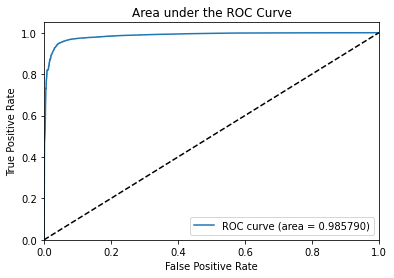

In [36]:
dtEval = BinaryClassificationEvaluator(labelCol = 'earthquake', rawPredictionCol = "probability", metricName = "areaUnderROC")
print('Test Area Under ROC', dtEval.evaluate(predictions))

results = predictions.select(['probability', 'earthquake'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][1]), float(i[1])) for i in results_collect]
#results_list

from sklearn.metrics import roc_curve, auc
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.6f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area under the ROC Curve')
plt.legend(loc="lower right")
plt.show()

### Metrics

In [37]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

print('Test Area Under ROC', dtEval.evaluate(predictions))
print('Accuracy: ', MulticlassClassificationEvaluator(labelCol='earthquake',metricName='accuracy').evaluate(predictions))
print('Precision: ',MulticlassClassificationEvaluator(labelCol='earthquake',metricName='weightedPrecision').evaluate(predictions))
print('Recall: ',MulticlassClassificationEvaluator(labelCol='earthquake',metricName='weightedRecall').evaluate(predictions))
print('F1: ',MulticlassClassificationEvaluator(labelCol='earthquake',metricName='weightedFMeasure').evaluate(predictions))

22/12/16 14:22:10 WARN DAGScheduler: Broadcasting large task binary with size 1839.8 KiB


Test Area Under ROC 0.985778116266918


22/12/16 14:22:16 WARN DAGScheduler: Broadcasting large task binary with size 1846.7 KiB


Accuracy:  0.9708495534246522


22/12/16 14:22:20 WARN DAGScheduler: Broadcasting large task binary with size 1846.7 KiB


Precision:  0.9828940003278588


22/12/16 14:22:24 WARN DAGScheduler: Broadcasting large task binary with size 1846.7 KiB


Recall:  0.9708495534246522


22/12/16 14:22:29 WARN DAGScheduler: Broadcasting large task binary with size 1846.7 KiB


F1:  0.9750256644332694


### Confusion Matrix

In [38]:
from pyspark.sql.types import FloatType
from pyspark.mllib.evaluation import MulticlassMetrics


#important: need to cast to float type, and order by prediction, else it won't work
preds_and_labels = predictions.select(['prediction','earthquake']).withColumn('label', F.col('earthquake').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

22/12/16 14:22:34 WARN DAGScheduler: Broadcasting large task binary with size 1831.9 KiB


22/12/16 14:22:36 WARN DAGScheduler: Broadcasting large task binary with size 1831.7 KiB


/opt/conda/lib/python3.7/site-packages/pyspark/sql/context.py:159: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


22/12/16 14:22:39 WARN DAGScheduler: Broadcasting large task binary with size 1818.3 KiB


22/12/16 14:22:40 WARN DAGScheduler: Broadcasting large task binary with size 1828.5 KiB


[[ 12735.   1449.]
 [ 13535. 486304.]]
